<a href="https://colab.research.google.com/github/katsuhiro-wq/katsuhiro-wq/blob/sub1/%E3%82%B7%E3%83%A3%E3%83%B3%E3%83%88%E9%9F%B3%E8%A7%A3%E6%9E%90%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%82%B3%E3%83%BC%E3%83%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch

In [ ]:
# === シャント音の録音ファイルを読み込む（10秒間録音） ===
filename = 'audio.wav'  # 音声ファイルのパス
# librosa.loadで音声ファイルを読み込み、波形データ y とサンプリングレート sr を取得
y, sr = librosa.load(filename)  # duration=10をつけると最初の10秒間のみ読み込む

In [ ]:
# === バンドパスフィルタの設計 ===
def butter_bandpass(lowcut, highcut, fs, order=5):
    """
    バターワースバンドパスフィルタを設計する関数

    Parameters:
    lowcut (float): 低周波数カットオフ（Hz）
    highcut (float): 高周波数カットオフ（Hz）
    fs (int): サンプリング周波数（Hz）
    order (int): フィルタの次数

    Returns:
    b, a (ndarray): フィルタ係数
    """
    nyq = 0.5 * fs  # ナイキスト周波数を計算
    low = lowcut / nyq  # 正規化した低周波数（0〜1の範囲）
    high = highcut / nyq  # 正規化した高周波数（0〜1の範囲）
    b, a = butter(order, [low, high], btype='band')  # バンドパスフィルタの係数を計算
    return b, a

In [ ]:
# === ノッチフィルタの設計と適用 ===
def apply_notch_filter(signal, freq, fs, quality_factor=30):
    """
    ノッチフィルタを適用して特定の周波数成分を除去する関数

    Parameters:
    signal (ndarray): 入力信号
    freq (float): 除去したい周波数（Hz）
    fs (int): サンプリング周波数（Hz）
    quality_factor (float): Q値（フィルタの鋭さ）

    Returns:
    y_notched (ndarray): フィルタリング後の信号
    """
    # ノッチ周波数を正規化（0〜1の範囲）
    w0 = freq / (fs / 2)
    # ノッチフィルタの係数を計算
    b, a = iirnotch(w0, quality_factor)
    # フィルタを適用してノッチング
    y_notched = lfilter(b, a, signal)
    return y_notched

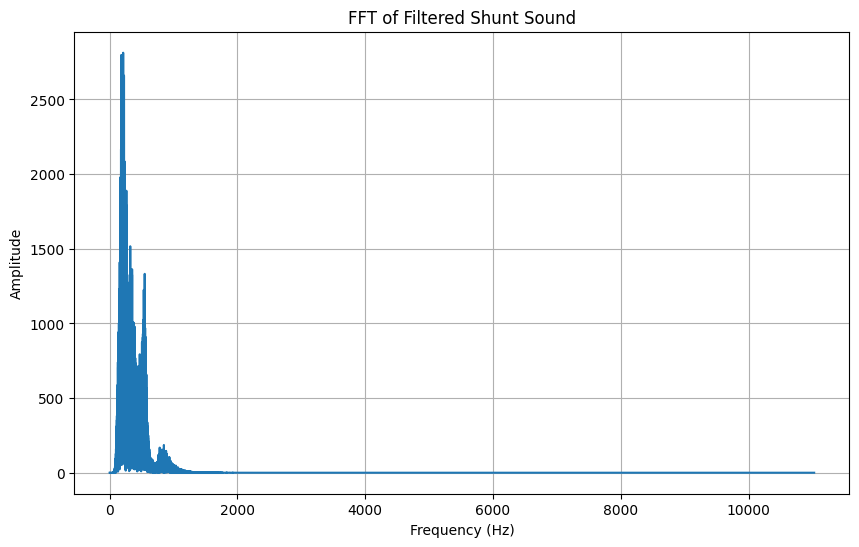

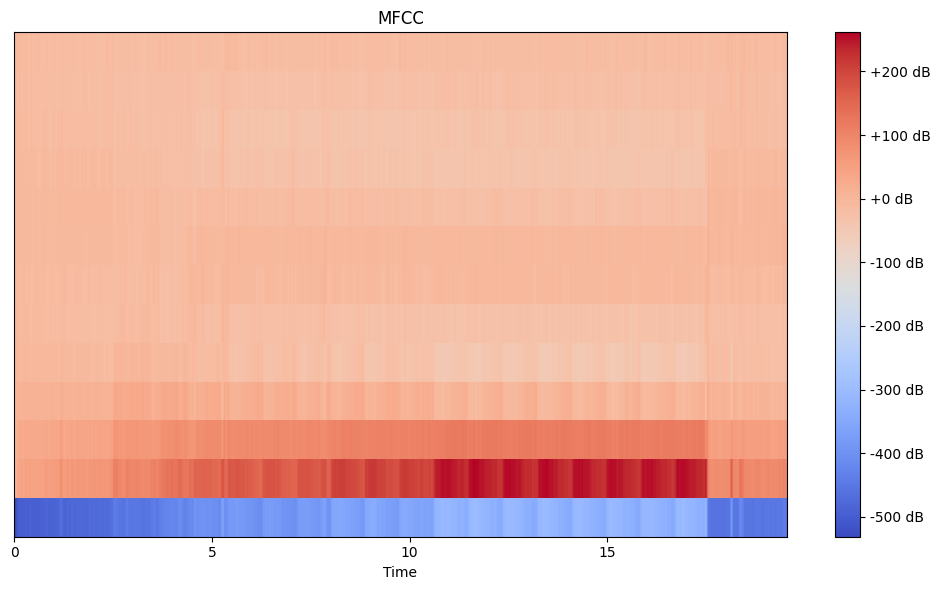

Peak Frequency: 212.06 Hz
MFCC Mean Coefficients: [-385.54439589  170.73811014   88.95496554   11.80632494  -24.44274742
  -21.82571237   -7.76812171   -4.87899652  -14.49330989  -24.45784187
  -25.95732543  -20.48800204  -14.2157953 ]


In [ ]:
# === フィルタリングの適用 ===
# フィルタのパラメータ設定
lowcut = 100.0  # 低周波数カットオフ（Hz）
highcut = 1000.0  # 高周波数カットオフ（Hz）

# バンドパスフィルタを設計し、信号に適用
b, a = butter_bandpass(lowcut, highcut, sr, order=5)
y_filtered = lfilter(b, a, y)

# ノッチフィルタの適用（例として50Hzを除去）
notch_freq = 50.0  # ノッチフィルタの周波数（Hz）
y_filtered = apply_notch_filter(y_filtered, notch_freq, sr)

# === FFT（フーリエ変換）による周波数解析 ===
fft_result = np.fft.fft(y_filtered)  # フーリエ変換を実行
fft_freqs = np.fft.fftfreq(len(fft_result), d=1/sr)  # 周波数軸を計算

# 振幅スペクトルをプロット（正の周波数成分のみ）
plt.figure(figsize=(10, 6))
plt.plot(fft_freqs[:len(fft_freqs)//2], np.abs(fft_result[:len(fft_result)//2]))
plt.title("FFT of Filtered Shunt Sound")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# === MFCC（メル周波数ケプストラム係数）の計算 ===
mfccs = librosa.feature.mfcc(y=y_filtered, sr=sr, n_mfcc=13)  # 13次のMFCCを計算

# MFCCをプロット
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

# === 特徴量の抽出（MFCCの係数やFFTのピークなど） ===
# ピーク周波数を計算（振幅が最大の周波数）
peak_idx = np.argmax(np.abs(fft_result[:len(fft_result)//2]))  # 正の周波数成分のみを考慮
peak_frequency = fft_freqs[peak_idx]

# MFCCの平均値を計算（各係数ごと）
mfcc_mean = np.mean(mfccs, axis=1)

print(f"Peak Frequency: {peak_frequency:.2f} Hz")
print(f"MFCC Mean Coefficients: {mfcc_mean}")


以下は恣意的にカットオフを決める場合

In [ ]:

# === 判定部分の例（シャント不全と比較する処理） ===
threshold_frequency = 200  # シャント不全の周波数基準（Hz）（例）
frequency_tolerance = 20  # 許容範囲（Hz）

# ピーク周波数と基準値を比較して判定
if abs(peak_frequency - threshold_frequency) < frequency_tolerance:
    print("シャント不全の可能性あり")
else:
    print("正常なシャント音")